# Executive Summary:

This project aims to identify behavioral and operational factors driving customer churn using a dataset of 7,955 customers with 32 features. Key findings indicate that payment failures increase churn risk, while higher satisfaction, longer tenure, and more monthly logins reduce it. A logistic regression model served as a baseline, achieving 89.6% accuracy and a ROC-AUC of 0.716, while a Random Forest captured potential nonlinear patterns but did not improve performance (accuracy 89.8%, ROC-AUC 0.712). Overall, churn is largely driven by linear relationships, highlighting engagement and financial behavior as critical levers for retention.


# 0. Environment Set up

In [84]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)


In [85]:
#Connect to Google Drive and load the data
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Colab Data/CustomerChurn.csv')
df.info()
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             10000 non-null  object 
 1   gender                  10000 non-null  object 
 2   age                     10000 non-null  int64  
 3   country                 10000 non-null  object 
 4   city                    10000 non-null  object 
 5   customer_segment        10000 non-null  object 
 6   tenure_months           10000 non-null  int64  
 7   signup_channel          10000 non-null  object 
 8   contract_type           10000 non-null  object 
 9   monthly_logins          10000 non-null  int64  
 10  weekly_active_days      10000 non-null  int64  
 11  avg_session_time        10000 non-null  float64
 12  features_used   

,customer_id,gender,age,country,city,customer_segment,tenure_months,signup_channel,contract_type,monthly_logins,...,avg_resolution_time,complaint_type,csat_score,escalations,email_open_rate,marketing_click_rate,nps_score,survey_response,referral_count,churn
0,CUST_00001,Male,68,Bangladesh,London,SME,22,Web,Monthly,26,...,13.354360,Service,4.0,0,0.71,0.40,27,Satisfied,1,0
1,CUST_00002,Female,57,Canada,Sydney,Individual,9,Mobile,Monthly,7,...,25.140088,Billing,2.0,0,0.78,0.33,-19,Neutral,2,1
2,CUST_00003,Male,24,Germany,New York,SME,58,Web,Yearly,19,...,27.572928,Service,3.0,0,0.35,0.49,80,Neutral,1,0
3,CUST_00004,Male,49,Australia,Dhaka,Individual,19,Mobile,Yearly,34,...,26.420822,Technical,5.0,1,0.83,0.15,100,Neutral,0,0
4,CUST_00005,Male,65,Bangladesh,Delhi,Individual,52,Web,Monthly,20,...,26.674579,Technical,4.0,0,0.65,0.44,21,Unsatisfied,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,CUST_09996,Female,67,Germany,Sydney,SME,37,Web,Yearly,15,...,34.240174,Service,4.0,1,0.36,0.28,20,Satisfied,2,0
9996,CUST_09997,Male,26,USA,Toronto,Individual,42,Mobile,Yearly,13,...,40.092087,NaN,4.0,0,0.48,0.06,28,Unsatisfied,2,0
9997,CUST_09998,Female,18,Canada,Sydney,Individual,39,Mobile,Yearly,15,...,25.215810,Technical,1.0,0,0.11,0.07,-30,Satisfied,1,0
9998,CUST_09999,Female,30,USA,Delhi,Individual,52,Web,Monthly,14,...,20.544921,NaN,2.0,0,0.25,0.31,58,Neutral,1,1


# 1. Pre Processing

In [86]:
#Dropping observations with missing values
df_cleaned = df.dropna()
print(f"Original DataFrame shape: {df.shape}")
print(f"Cleaned DataFrame shape after dropping rows with missing values: {df_cleaned.shape}")

Original DataFrame shape: (10000, 32)
Cleaned DataFrame shape after dropping rows with missing values: (7955, 32)


In [87]:
# Modify column names, replacing empty spaces with _
df_cleaned.columns = [x.replace(' ', '_') for x in df_cleaned.columns]
list(df_cleaned.columns)

['customer_id',
 'gender',
 'age',
 'country',
 'city',
 'customer_segment',
 'tenure_months',
 'signup_channel',
 'contract_type',
 'monthly_logins',
 'weekly_active_days',
 'avg_session_time',
 'features_used',
 'usage_growth_rate',
 'last_login_days_ago',
 'monthly_fee',
 'total_revenue',
 'payment_method',
 'payment_failures',
 'discount_applied',
 'price_increase_last_3m',
 'support_tickets',
 'avg_resolution_time',
 'complaint_type',
 'csat_score',
 'escalations',
 'email_open_rate',
 'marketing_click_rate',
 'nps_score',
 'survey_response',
 'referral_count',
 'churn']

In [88]:
# Define target and ID columns
target_col = "churn"
id_cols = ["customer_id"] if "customer_id" in df_cleaned.columns else []

# Define y (target) and X (features)
y = df_cleaned[target_col]
X = df_cleaned.drop(columns=[target_col] + id_cols)

In [89]:
# Split data
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.4, random_state = 1, stratify = y)

In [90]:
# Stratify on:
print( "Number of 1's in training set:", sum(y_train))
print( "Number of 1's in testing set:", sum(y_test))
print( "Proportion of 1's in testing set", sum(y_test)/(sum(y_train)+sum(y_test)))

Number of 1's in training set: 486
Number of 1's in testing set: 324
Proportion of 1's in testing set 0.4


In [93]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7955 entries, 0 to 9999
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             7955 non-null   object 
 1   gender                  7955 non-null   object 
 2   age                     7955 non-null   int64  
 3   country                 7955 non-null   object 
 4   city                    7955 non-null   object 
 5   customer_segment        7955 non-null   object 
 6   tenure_months           7955 non-null   int64  
 7   signup_channel          7955 non-null   object 
 8   contract_type           7955 non-null   object 
 9   monthly_logins          7955 non-null   int64  
 10  weekly_active_days      7955 non-null   int64  
 11  avg_session_time        7955 non-null   float64
 12  features_used           7955 non-null   int64  
 13  usage_growth_rate       7955 non-null   float64
 14  last_login_days_ago     7955 non-null   int64

# 2. Run Logistic Regression

In [66]:
#Preparing your churn data (numeric + categorical), standardizes it, one-hot encodes it, and builds a logistic regression model in a single pipeline.
# Identify column types
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

# Preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop="first", handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Logistic regression model
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=1000))
    ]
)


In [67]:
# Make sure model is fit
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['age', 'tenure_months', 'monthly_logins', 'weekly_active_days',
       'avg_session_time', 'features_used', 'usage_growth_rate',
       'last_login_days_ago', 'monthly_fee', 'total_revenue',
       'payment_failures', 'support_tickets', 'avg_resolution_time',
       'csat_score', 'escalations', 'e...
       'nps_score', 'referral_count'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['gender', 'country', 'city', 'customer_segment', 'signup_channel',
       'contract_type', 'payment_method', 'discount_applied',
       'price_increase_last_3m', 'complaint_type', 'survey_response'],
      dtype='object'))])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [81]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score


# 1. Make predictions (AFTER model is trained)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# 2. Evaluate model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

# 3. Show results cleanly
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"],
    "Value": [accuracy, precision, recall, f1, auc]
})

metrics_df



,Metric,Value
0,Accuracy,0.895977
1,Precision,0.315789
2,Recall,0.018519
3,F1-score,0.034985
4,ROC-AUC,0.716084


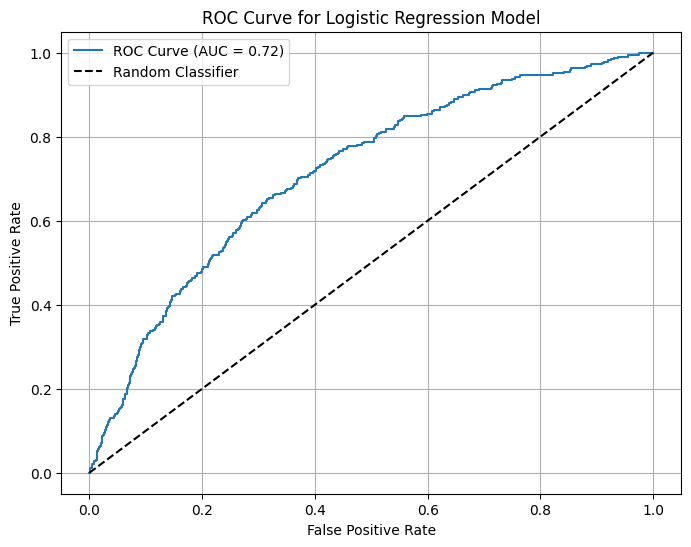

In [82]:
# 4. Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression Model')
plt.legend()
plt.grid(True)
plt.show()

In [69]:
# Get feature names
numeric_feature_names = numeric_features.tolist()
categorical_feature_names = (
    model.named_steps["preprocessor"]
    .named_transformers_["cat"]
    .get_feature_names_out(categorical_features)
    .tolist()
)

feature_names = numeric_feature_names + categorical_feature_names

# Get coefficients
coefficients = model.named_steps["classifier"].coef_[0]

# Create dataframe
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", key=abs, ascending=False)

# Print top drivers
print(coef_df.head(15))


                        Feature  Coefficient
13                   csat_score    -0.540969
1                 tenure_months    -0.422750
2                monthly_logins    -0.378256
10             payment_failures     0.368544
28                  city_London    -0.317811
26                   city_Delhi     0.299824
34      signup_channel_Referral     0.266747
23                country_India    -0.244575
39        payment_method_PayPal    -0.230612
45  survey_response_Unsatisfied     0.211101
20           country_Bangladesh    -0.144164
38          payment_method_Card    -0.139319
19                  gender_Male     0.136780
44    survey_response_Satisfied     0.131600
7           last_login_days_ago     0.131583


In [70]:
top_4_coefficients = coef_df.head(4)
print(top_4_coefficients)


             Feature  Coefficient
13        csat_score    -0.540969
1      tenure_months    -0.422750
2     monthly_logins    -0.378256
10  payment_failures     0.368544


# 4. Random Forest

In [76]:
# Get the preprocessor from the existing model pipeline
preprocessor = model.named_steps['preprocessor']

# Process the training and testing data using the preprocessor
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train_processed, y_train)

rf_pred = rf.predict(X_test_processed)


In [77]:
#Evaluating Accuracy for Decision Tree

print("RF Accuracy:", accuracy_score(y_test, rf_pred))
print("RF Precision:", precision_score(y_test, rf_pred))
print("RF Recall:", recall_score(y_test, rf_pred))

RF Accuracy: 0.8984915147705845
RF Precision: 1.0
RF Recall: 0.0030864197530864196
